In [13]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import sklearn
from tqdm import tqdm
df = pd.read_csv('movie10k.csv')

In [14]:
df.isnull().sum()
#0 null so no need to clear null
print(df.duplicated().sum())
#418 duplicated, no we need to clear duplicates
df=df.drop_duplicates() 
print(df.duplicated().sum())
#duplicates are cleared
df.head()

13
0


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [15]:
import re
def stringClear(text):
    cleanText = re.sub(r'[!,.""?''()]',' ',text)
    return cleanText

df['text'] = df['text'].apply(stringClear)
df['text'] = df['text'].apply(lambda x: x.lower())
df.head()

,text,label
0,i grew up b 1965 watching and loving the th...,0
1,when i put this movie in my dvd player and sa...,0
2,why do people who do not know what a particula...,0
3,even though i have great interest in biblical ...,0
4,im a die hard dads army fan and nothing will e...,1


In [16]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWordList = stopwords.words("english")

df['text'] = df['text'].apply(lambda x: [item for item in x.split() if item not in stopWordList]).apply(lambda x:" ".join(x))
#unnecessary words are eliminated
df.head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eceok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label
0,grew b 1965 watching loving thunderbirds mates...,0
1,put movie dvd player sat coke chips expectatio...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movies bor...,0
4,im die hard dads army fan nothing ever change ...,1
5,terrible movie everyone said made laugh cameo ...,0
6,finally watched shocking movie last night dist...,1
7,caught film azn cable sounded like would good ...,0
8,may remake 1987 autumn's tale eleven years dir...,1
9,super ex girlfriend turned pleasant surprise r...,1


In [17]:

def catAsNum(val):
    if val=="positive":
        return 1
    else:
        return 0
#df['label']  =  df['label'].apply(catAsNum)

In [18]:
x = df["text"].values
y = df["label"].values

In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2) 
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(7989,)
(1998,)
(7989,)
(1998,)


In [20]:
from transformers import AutoTokenizer, DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(list(x_train), padding = "max_length", truncation=True)
test_encodings = tokenizer(list(x_test), padding = "max_length", truncation=True)

BATCHSIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(BATCHSIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(BATCHSIZE)


In [21]:
for x, y in test_dataset:
   print(x, y)

{'input_ids': <tf.Tensor: shape=(64, 512), dtype=int32, numpy=
array([[  101,  2442, 18443, ...,     0,     0,     0],
       [  101,  5719,  5164, ...,     0,     0,     0],
       [  101, 20774,  7585, ...,     0,     0,     0],
       ...,
       [  101,  3383,  3167, ...,     0,     0,     0],
       [  101,  2502,  5470, ...,     0,     0,     0],
       [  101,  6919,  2143, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(64, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>} tf.Tensor(
[0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1
 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1], shape=(64,), dtype=int64)
{'input_ids': <tf.Tensor: shape=(64, 512), dtype=int32, numpy=
array([[  101,  2728,  3233, ...,     0,     0,     0],
       [  101,  2588,  2

In [22]:
id2label = {
    0 : 'Negative',
    1 : 'Positive'
}

label2id = {v : k for k, v in id2label.items()}
num_classes = len(label2id)
print(label2id)

{'Negative': 0, 'Positive': 1}


In [23]:
#cased
from transformers import TFAutoModelForSequenceClassification
model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels = 2,
    label2id = label2id,
    id2label = id2label
)

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5), #hyperparameter
    metrics = ["accuracy"] #hyperparameter sayılır
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_39', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [24]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [27]:
from numba import jit, cuda
@jit(target_backend='cuda')  
def func():
    EPOCHS = 1 #hyperparameter
    history = model.fit(
        train_dataset,
        validation_data = test_dataset,
        epochs = EPOCHS
    )
    return history
history = func()

C:\Users\eceok\AppData\Local\Temp\ipykernel_17688\57715500.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(target_backend='cuda')
C:\Users\eceok\AppData\Local\Temp\ipykernel_17688\57715500.py:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "func" failed type inference due to: Untyped global name 'model': Cannot determine Numba type of <class 'transformers.models.distilbert.modeling_tf_distilbert.TFDistilBertForSequenceClassification'>

File "..\..\..\..\AppData\Local\Temp\ipykernel_17688\57715500.py", line 5:
<source missing, REPL/exec in use?>

  @jit(target_backend='cuda')
c:\Users\eceok\anaconda3\lib\site-pa

125/125 [==============================] - 7902s 63s/step - loss: 0.2088 - accuracy: 0.9243 - val_loss: 0.3296 - val_accuracy: 0.8684


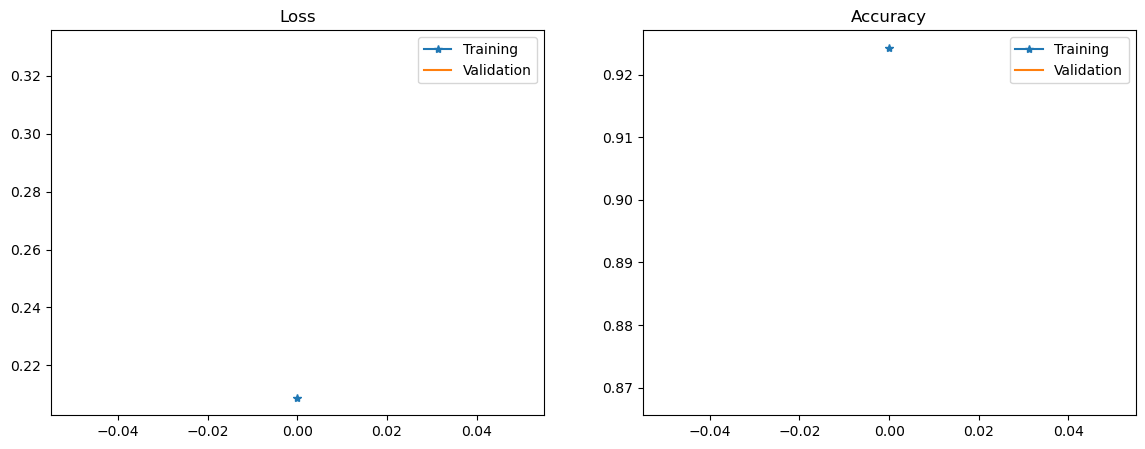

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = '*', label = 'Training')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = '*', label = 'Training')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.legend()

In [29]:
out = model.predict(test_dataset)
pred = np.argmax(out[0], axis = 1)
pred

32/32 [==============================] - 313s 10s/step


array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

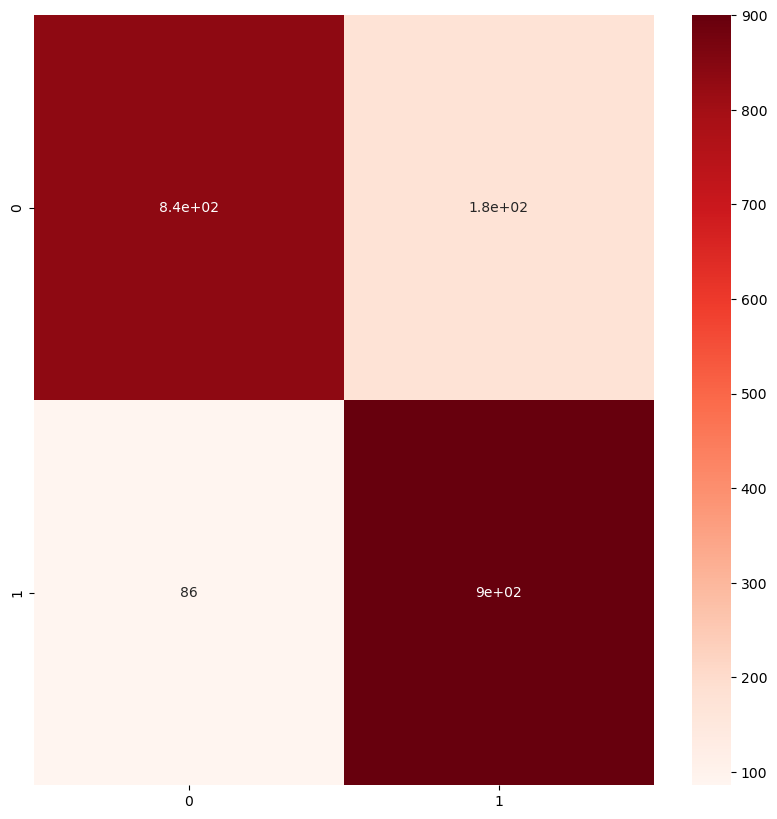

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, pred)
plt.subplots(figsize = (10, 10))
sns.heatmap(cm, annot = True, cmap='Reds')
plt.show()